# 0.0. Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px

## 0.1 Helper Functions

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

def change_date(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    return data[column]

def descrever(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.median)).T

    min_ = pd.DataFrame(num_attributes.apply(np.min)).T
    max_ = pd.DataFrame(num_attributes.apply(np.max)).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T
    range_ =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis  = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    unique  = pd.DataFrame(num_attributes.apply(lambda x: x.nunique())).T
    cv = pd.DataFrame(num_attributes.apply(lambda x: np.std(x) / np.mean(x))).T


    metricas = pd.concat([ min_, max_, range_, mean, median, std, skew, kurtosis, unique, cv]).T
    metricas.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'unique', 'cv']
    return metricas
    
pd.set_option('display.float_format', lambda x: '%.5f' % x)


def taxa_leitura(cluster=None):
    
    if cluster:
        aux = df_mensagem[df_mensagem['cluster']==cluster][['contrato_id','status', 'acao']].groupby(['acao', 'status' ]).count().reset_index()
    else:
        aux = df_mensagem[['contrato_id','status', 'acao']].groupby(['acao', 'status' ]).count().reset_index()
    
    
    total = aux[aux['status']!='NAO ENTREGUE']
    lido = total[total['status']!='ENTREGUE']

    aux = total.groupby('acao').sum().reset_index().rename(columns={'contrato_id':'entregues'})
    aux1 = lido.groupby('acao').sum().reset_index().rename(columns={'contrato_id':'lidos'})

    aux = pd.merge(aux, aux1, on='acao', how='left')
    aux['taxa_leitura'] = aux['lidos']/aux['entregues']
    aux = aux.sort_values('taxa_leitura', ascending=False)
    
    return aux[['acao', 'taxa_leitura']]


def media_multiplas_campanhas(n):
    #agrupar acoes em cada dia, contando quantas mensagens foram enviadas e a eficiencia mediaa
    n_mensagens_dia = df_mensagem[['contrato_id', 'data_acao', 'acao', 'status', 'eficiencia', 'status']].groupby(['contrato_id', 'data_acao']).agg(n_mensagens = ('contrato_id', 'count'),eficiencia = ('eficiencia', 'mean')).reset_index().dropna()
    n_mensagens_dia = pd.merge(n_mensagens_dia, df_contrato['contrato_id'], on='contrato_id', how='left') 

    aux = pd.merge(n_mensagens_dia, df_mensagem[['status', 'contrato_id', 'data_acao']], on = ['contrato_id', 'data_acao'], how='inner')
    aux = aux[aux['n_mensagens']==n]
    
    #dummies do status da mensagem
    aux = pd.get_dummies(aux, prefix='', columns=['status'])
    
    #somando para ver o total entregue e total lido em cada dia
    aux0 = aux[['contrato_id','data_acao', '_ENTREGUE','_LIDO', '_NAO ENTREGUE', '_RESPONDIDO']].groupby(['contrato_id','data_acao']).sum().reset_index()
   
    #calculando total entregue
    aux0['entregues'] = aux0['_ENTREGUE'] + aux0['_LIDO'] + aux0['_RESPONDIDO']
    
    #calculando total lido
    aux0['lidos'] =  aux0['_LIDO'] + aux0['_RESPONDIDO']
    
    #calculando taxa de leitura
    aux0['taxa_leitura'] = aux0['lidos']/aux0['entregues']
    aux0 = aux0[['contrato_id', 'data_acao', 'entregues', 'lidos', 'taxa_leitura']]
    
    #retornando a media da taxa de leitura para n mensagens repetidas
    return aux0['taxa_leitura'].mean()



## 0.3. Load Data 

In [3]:
df_geral = pd.read_csv('../data/dfs_cluster/df_geral.csv')
df_mensagem = pd.read_csv('../data/dfs_cluster/df_mensagem.csv')
df_contrato = pd.read_csv('../data/dfs_cluster/df_contrato.csv')

# 1.0. Preparação dos Dados

## 1.1. Mudar tipo de data


In [4]:
#df_contrato
dates = ['dt_contrato', 'dt_desembolso','dt_vencimento', 'dt_wo', 'ultima_data']
for date in dates:
    df_contrato[date] = change_date(df_contrato, date)
    

#df_mensagem
df_mensagem['data_acao'] = change_date(df_mensagem, 'data_acao')
df_mensagem['dt_ref_portfolio'] = change_date(df_mensagem, 'dt_ref_portfolio')

#df_geral
df_geral['dt_ref_portfolio'] = change_date(df_geral, 'dt_ref_portfolio')


# EDA

In [5]:
ativos = df_contrato[df_contrato['status_contrato']=='Active']

# 7.0. EDA

In [6]:
metricas = ['contrato_id', 'prazo', 'vlr_desembolsado', 'vlr_tarifa',
'juros_diario', 'tipo_empresa', 'cidade', 'estado',
'subsegmento', 'segmento', 'status_contrato', 'dsp',
'dspp', 'dsp_atual', 'dspp_atual','vlr_pgto_realizado', 'valor_pago_tpv', 'valor_total_pago',
'debito_sem_pagamento', 'tempo_esperado', 'dias_de_contrato',
'n_acoes_total', 'n_acoes_entregues', 'saldo_devedor_acumulado',
'debito', 'mensagens_lidas', 'taxa_leitura', 'taxa_entregue',
'eficiencia', 'dias_de_atraso', 'pgto_medio', 'dias_restantes',
'ritmo_esperado', 'razao', 'cluster']

cluster0 = df_contrato[df_contrato['cluster']==0][metricas]
cluster1 = df_contrato[df_contrato['cluster']==1][metricas]
cluster2 = df_contrato[df_contrato['cluster']==2][metricas]

In [7]:
backup_m = df_mensagem.copy()

In [8]:
df_mensagem = backup_m 

#diferencianado campanhas de boleto quitado
df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dsp']==15) , 'acao'] = 'campanhaboletoquitado15'
df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dsp']==90) , 'acao'] = 'campanhaboletoquitado90'
df_mensagem.loc[(df_mensagem['acao']=='campanhaboletoquitado') & (df_mensagem['dspp']==45) , 'acao'] = 'campanhaboletoquitado45'
df_mensagem.loc[(df_mensagem['acao']=='campanhaobservacao') & (df_mensagem['dsp']==5) , 'acao'] = 'campanhaobservacao05'
df_mensagem.loc[(df_mensagem['acao']=='campanhaobservacao') & (df_mensagem['dspp']==15) , 'acao'] = 'campanhaobservacao15'
df_mensagem.loc[(df_mensagem['acao']=='campanhaparcelamento') & (df_mensagem['dsp']==10) , 'acao'] = 'campanhaparcelamento10'
df_mensagem.loc[(df_mensagem['acao']=='campanhaparcelamento') & (df_mensagem['dspp']==30) , 'acao'] = 'campanhaparcelamento30'

## Clusters DF

In [9]:
cluster0 = df_contrato[(df_contrato['cluster']==0) & (df_contrato['status_contrato']=='Active')]
cluster1 = df_contrato[(df_contrato['cluster']==1) & (df_contrato['status_contrato']=='Active')]
cluster2 = df_contrato[(df_contrato['cluster']==2) & (df_contrato['status_contrato']=='Active')]


a = sum(cluster0['status_contrato']=='Active')
print(f'Nº de engajados com contrato ativo: {a}')
a = sum(cluster1['status_contrato']=='Active')
print(f'\nNº de desengajados com contrato ativo: {a}')
a = sum(cluster2['status_contrato']=='Active')
print(f'\nNº de bons pagantes com contrato ativo: {a}')


Nº de engajados com contrato ativo: 3720

Nº de desengajados com contrato ativo: 1760

Nº de bons pagantes com contrato ativo: 1308


# 1. Taxa de Mensagens Entregues

In [10]:
aux = np.round(df_contrato['n_acoes_entregues'].sum()/df_contrato['n_acoes_total'].sum(),3)*100
print(f'{aux}% dos comunicados enviados são entregues')

52.6% dos comunicados enviados são entregues


## 1.1. Por tipo 

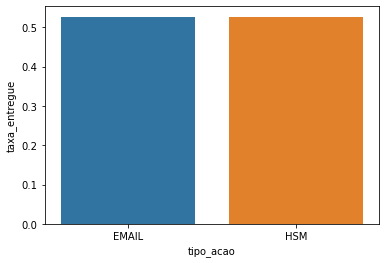

In [11]:
nao_entregue = df_mensagem[df_mensagem['status']=='NAO ENTREGUE'][['contrato_id','status', 'tipo_acao']].groupby (['status', 'tipo_acao']).count().reset_index()
nao_entregue = nao_entregue[['tipo_acao', 'contrato_id']].groupby('tipo_acao').sum().reset_index().rename(columns = {'contrato_id': 'nao_entregues'})

entregue = df_mensagem[df_mensagem['status']!='NAO ENTREGUE'][['contrato_id','status', 'tipo_acao']].groupby (['status', 'tipo_acao']).count().reset_index()
entregue = entregue[['tipo_acao', 'contrato_id']].groupby('tipo_acao').sum().reset_index().rename(columns = {'contrato_id': 'entregues'})


aux = pd.merge(entregue, nao_entregue, on ='tipo_acao', how='left')
aux['taxa_entregue'] = aux['entregues']/(aux['entregues']+aux['nao_entregues'])
sns.barplot(data = aux, x='tipo_acao', y='taxa_entregue');


A taxa de envio é a mesma para os dois tipos

## 1.2. Taxa de envio por campanha

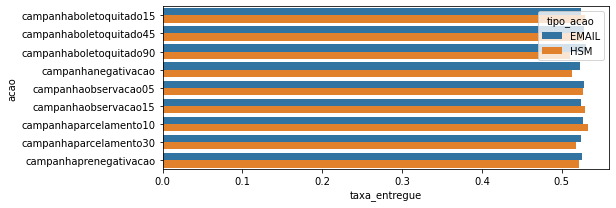

In [12]:
nao_entregue = df_mensagem[df_mensagem['status']=='NAO ENTREGUE'][['contrato_id','status', 'tipo_acao', 'acao']].groupby (['status', 'tipo_acao', 'acao']).count().reset_index()
nao_entregue = nao_entregue[['tipo_acao','acao', 'contrato_id']].groupby(['acao','tipo_acao']).sum().reset_index().rename(columns = {'contrato_id': 'nao_entregues'})

entregue = df_mensagem[df_mensagem['status']!='NAO ENTREGUE'][['contrato_id','status', 'tipo_acao', 'acao']].groupby (['status', 'tipo_acao', 'acao']).count().reset_index()
entregue = entregue[['tipo_acao','acao', 'contrato_id']].groupby(['acao','tipo_acao']).sum().reset_index().rename(columns = {'contrato_id': 'entregues'})

aux = pd.merge(entregue, nao_entregue, on =['tipo_acao' , 'acao'], how='left')
aux['taxa_entregue'] = aux['entregues']/(aux['entregues']+aux['nao_entregues'])
plt.figure(figsize=(8,3))

sns.barplot(data = aux, x='taxa_entregue',y='acao', hue='tipo_acao');

Não há diferença relevante por ação.

**CONCLUSÃO**: Geralmente um pouco mais da metade das mensagens são entregues, mas não há muita razão apontada nos dados para isso acontecer. Conseguir novos dados para descobrir a razão das mensagens não serem entregues poderia ajudar a mapear a raiz desse problema.

# 2.0. Taxa de leitura

In [13]:
aux = np.round(df_contrato['mensagens_lidas'].sum()/df_contrato['n_acoes_entregues'].sum(),3)*100
print(f'{aux}% dos comunicados entregues são lidos')
aux = np.round(df_contrato['mensagens_lidas'].sum()/df_contrato['n_acoes_total'].sum(),3)*100
print(f'{aux}% dos comunicados enviados são lidos')

35.099999999999994% dos comunicados entregues são lidos
18.5% dos comunicados enviados são lidos


## 2.1. Taxa de Leitura por Campanha

In [14]:
df = taxa_leitura()
df['dia'] = [60, 15, 30, 10, 15, 5, 45,30 ,90]

dsp = ['campanhaobservacao05',
'campanhaparcelamento10',
'campanhaboletoquitado15',
'campanhaprenegativacao',
'campanhanegativacao',
'campanhaboletoquitado90']

dspp = ['campanhaobservacao15',
'campanhaparcelamento30',
'campanhaboletoquitado45',]

df_dsp = df[df['acao'].isin(dsp)].sort_values('dia').reset_index()
df_dspp = df[df['acao'].isin(dspp)].sort_values('dia').reset_index()
df = df.sort_values('dia').reset_index()

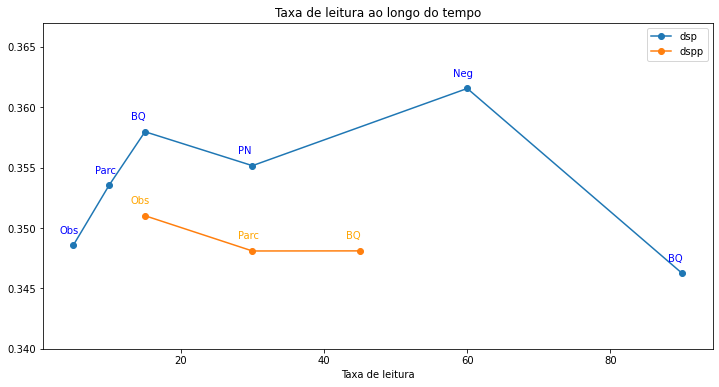

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_dsp['dia'], df_dsp['taxa_leitura'], marker='o');
plt.plot(df_dspp['dia'], df_dspp['taxa_leitura'], marker='o');
plt.xlabel('Dia')
plt.xlabel('Taxa de leitura')
plt.title('Taxa de leitura ao longo do tempo')
plt.legend(['dsp', 'dspp']);
plt.ylim(0.34, 0.367)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN', 'Neg', 'BQ']
d_dsp = [5,10,15, 30, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [15, 30, 45]

for i in range(len(d_dsp)):
    plt.annotate(c_dsp[i], (d_dsp[i]-2,df_dsp['taxa_leitura'][i]+0.001), color='blue')

for i in range(len(d_dspp)):
    plt.annotate(c_dspp[i], (d_dspp[i]-2,df_dspp['taxa_leitura'][i]+0.001), color='orange')



In [16]:
range_ = np.round(df['taxa_leitura'].max() - df['taxa_leitura'].min(), 5)
print(f'O range entre as taxas é de {range_}')

O range entre as taxas é de 0.0153


A taxa de leitura não varia muito ao longo do tempo, mas parece decair um pouco ao longo do tempo seguindo próximo da média da taxa de leitura.



## 2.2. Taxa de leitura por tipo

In [17]:
nao_lido = df_mensagem[df_mensagem['status']=='ENTREGUE'][['contrato_id','status', 'tipo_acao']].groupby (['status', 'tipo_acao']).count().reset_index()
nao_lido = nao_lido[['tipo_acao', 'contrato_id']].groupby('tipo_acao').sum().reset_index().rename(columns = {'contrato_id': 'nao_lidos'})

lido = df_mensagem[df_mensagem['status'].isin(['LIDO', 'RESPONDIDO'])][['contrato_id','status', 'tipo_acao']].groupby (['status', 'tipo_acao']).count().reset_index()
lido = lido[['tipo_acao', 'contrato_id']].groupby('tipo_acao').sum().reset_index().rename(columns = {'contrato_id': 'lidos'})


aux = pd.merge(lido, nao_lido, on ='tipo_acao', how='left')
aux['taxa_leitura'] = aux['lidos']/(aux['nao_lidos']+aux['lidos'])
aux[['tipo_acao', 'taxa_leitura']]

,tipo_acao,taxa_leitura
0,EMAIL,0.35184
1,HSM,0.35010


Não há diferença na taxa de leitura entre os canais.


## 2.3. Mais de uma campanha no dia

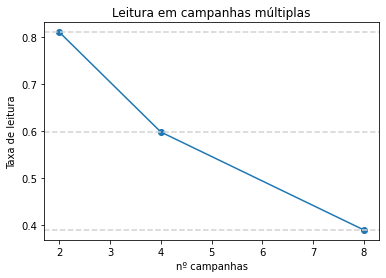

In [18]:
taxas_multiplas_campanhas = [media_multiplas_campanhas(2),media_multiplas_campanhas(4),media_multiplas_campanhas(8)]
n_campanhas=  [2,4,8]

plt.plot(n_campanhas, taxas_multiplas_campanhas, marker='o')
for i in range(3):
    plt.axhline(taxas_multiplas_campanhas[i], linestyle='--', color='lightgrey')
plt.title('Leitura em campanhas múltiplas')
plt.xlabel('nº campanhas')
plt.ylabel('Taxa de leitura');



Não é eficiente mandar mais de uma campanha em um dia, pois dificilmente o contratante vai ler mais de uma. É interessante priorizar o tipo de ação mais eficiente para enviar caso o contrato esteja nas duas regras de acionamento ao mesmo tempo. Ou então utilizar a mesma mensagem para duas campanhas.

**Taxa de leitura = Lido / Total Entregue** (analisado nos dias que foram enviadas, 2, 4 e 8 mensagens)

# 3.0. Eficiência

In [19]:
aux = int(df_mensagem['eficiencia'].mean()*100)

print(f'A eficiência das mensagens lidas é de {aux}%, ou seja, a cada 100 mensagens lidas {aux} voltam a pagar')

A eficiência das mensagens lidas é de 37%, ou seja, a cada 100 mensagens lidas 37 voltam a pagar


A eficiência das mensagens podem variar de acordo com tipo, campanha, canal, tempo, e isso que vamos investigar agora.

## 3.1. Por canal de comunicação

In [20]:
df_mensagem[['tipo_acao', 'eficiencia']].groupby('tipo_acao').mean().reset_index()

,tipo_acao,eficiencia
0,EMAIL,0.37918
1,HSM,0.37230


Não há muita distinção entre a eficiência entre os canais de comunicação.

## 3.2. Por campanha

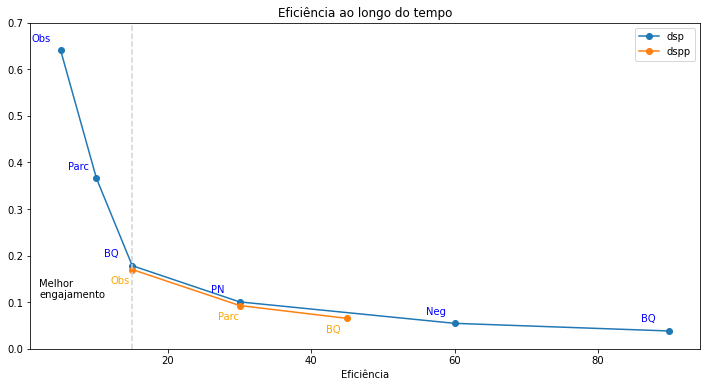

In [21]:
df = df_mensagem[['eficiencia', 'acao']].groupby('acao').mean().reset_index()
df = df.sort_values('eficiencia', ascending=False)
df['dia'] = [5,10,15,15, 30, 30,45,60, 90] 

df_dsp = df[df['acao'].isin(dsp)].sort_values('dia').reset_index(drop=True)
df_dspp = df[df['acao'].isin(dspp)].sort_values('dia').reset_index(drop=True)
df = df.sort_values('dia').reset_index(drop=True)

plt.figure(figsize=(12,6))
plt.plot(df_dsp['dia'], df_dsp['eficiencia'], marker='o');
plt.plot(df_dspp['dia'], df_dspp['eficiencia'], marker='o');
plt.xlabel('Dia')
plt.xlabel('Eficiência')
plt.title('Eficiência ao longo do tempo')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN', 'Neg', 'BQ']
d_dsp = [5,10,15, 30, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [15, 30, 45]

for i in range(len(d_dsp)):
    plt.annotate(c_dsp[i], (d_dsp[i]-4,df_dsp['eficiencia'][i]+0.02), color='b')

for i in range(len(d_dspp)):
    plt.annotate(c_dspp[i], (d_dspp[i]-3,df_dspp['eficiencia'][i]-0.03), color='orange')
    
plt.axvline(15, color='lightgrey', linestyle='--')
plt.annotate('Melhor \nengajamento',(2, 0.11) );


Aqui finalmente vemos alguma variação.
 
**Conclusões importantes:**
1. O intervalo onde o cliente está **mais engajado** é **até 15 dias**. Se ele passar desse tempo, será muito mais difícil conseguir fazê-lo pagar.  
2. Depois de 15 dias, é mais fácil alcançar quem não está pagando o principal (dspp) do que aquele que está sem pagar nada (dsp).

**Ações:**
1. Evitar que o cliente fique mais de 15 dias sem pagar. 
2. Localizar clientes que estão há mais de 30 dias e fazer um contato mais direto, para entender a situação e oferecer oportunidade de quitar. (criar lista priorizando aqueles que devem mais e são mais prováveis de pagar).

**Melhorar eficiência da campanha de boleto quitado**


# 4.0. Clusters

In [27]:
metricas = ['contrato_id','nome_cluster', 'dsp', 'dspp', 'debito', 'taxa_leitura', 'eficiencia', 'dias_de_atraso', 'n_acoes_total', 'pgto_medio', 'prazo', 'ritmo_esperado']

df_cluster = (df_contrato[metricas].groupby('nome_cluster').agg(
                             debito = ('debito', 'mean'),
                             taxa_leitura = ('taxa_leitura', 'mean'),
                             eficiencia = ('eficiencia', 'mean'),
                             dias_de_atraso = ('dias_de_atraso', 'mean'),
                             n_acoes_total = ('n_acoes_total', 'mean'),
                             pgto_medio = ('pgto_medio', 'mean'),                              
                             ritmo_esperado = ('ritmo_esperado', 'mean'), 
                             dsp = ('dsp', 'median'),
                             dspp = ('dspp', 'median'),
                             n_contratos = ('contrato_id', 'count'))).reset_index()

df_cluster

,nome_cluster,debito,taxa_leitura,eficiencia,dias_de_atraso,n_acoes_total,pgto_medio,ritmo_esperado,dsp,dspp,n_contratos
0,bons_pagadores,11559.35000,0.15739,0.16972,5.58150,2.16926,152.85857,28.81136,0.55610,0.97059,5601
1,desengajados,55743.22799,0.34792,0.14129,52.10959,35.67157,68.25197,187.71620,13.90096,51.83363,5639
2,engajados,33106.46128,0.35540,0.66540,39.58305,42.34187,63.81869,113.31898,2.16229,12.37304,3516


**Bons pagantes**

* Pagam bem e constantemente, portanto recebem poucas mensagens.

**Engajados**

* Pagam com pouca constante, portanto recebem muitas mensagens.
* As mensagens são mais eficientes nesse grupo.

**Desengajados**

* Pagam com pouca constante, portanto recebem muitas mensagens.
* As mensagens são menos eficientes nesse grupo.



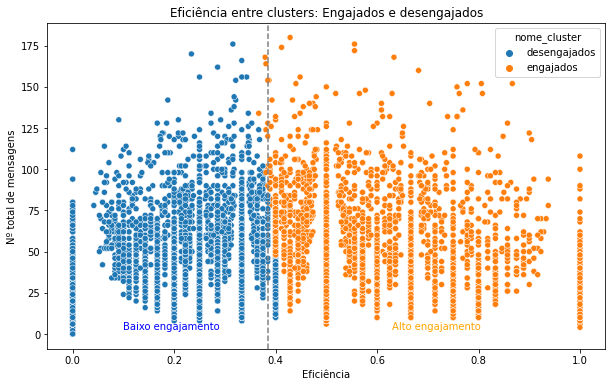

In [28]:
plt.figure(figsize=(10,6))

aux = df_contrato[df_contrato['nome_cluster']!='bons_pagadores']

sns.scatterplot(data=aux, x='eficiencia', y='n_acoes_total', hue='nome_cluster')
plt.title('Eficiência entre clusters: Engajados e desengajados')
plt.axvline(0.385, linestyle='--', color='grey')
plt.xlabel('Eficiência')
plt.ylabel('Nº total de mensagens')
plt.annotate('Baixo engajamento', (0.1, 2.5), color='b')
plt.annotate('Alto engajamento', (0.63, 2.5), color='orange');


# 5.0. Nova régua

## 5.1. Régua dspp

In [29]:
df_dspp

,acao,eficiencia,dia
0,campanhaobservacao15,0.17015,15
1,campanhaparcelamento30,0.09285,30
2,campanhaboletoquitado45,0.06529,45


In [30]:
x = np.round(df_dspp['eficiencia'].mean(),2)*100

print(f'A eficiência da régua dspp tá muito baixa, a média é {x}%. Pelo gráfico, é possível observar que o engajamento segue a mesmaa tendência das campanhas de régua dsp para os mesmos dias')


A eficiência da régua dspp tá muito baixa, a média é 11.0%. Pelo gráfico, é possível observar que o engajamento segue a mesmaa tendência das campanhas de régua dsp para os mesmos dias


Pode ser uma boa ideia deslocar o tempo de acionamento da régua dspp para conseguir uma eficácia maior.


#### Zonas de engajamento
* Zona de engajamento [0 - 14] dias sem pagar (tanto dsp quanto dspp)
* Zona de desengajamento [15 - 60]
* Zona perdida [60 +]

#### **Régua dspp**

* Colocar as campanhas de régua dspp para 5 dias antes e tentar pegar um engajamento maior, tentando seguir a mesma lógica da curva de engajamento de régua dsp.


#### **Novas campanhas**

* Adicionar uma  **nova campanha de Parcelamento** entre Pré-negativação e Negativação, como uma saída para o cliente evitar a negativação e evitar que entre na zona perdida, onde a probabilidade de retornar pagamento é muito baixa.

#### **Obs** :

* Utilizar ligação ou contato presencial no caso de clientes desengajados com débitos muito grandes. 
* No dashboard é possível encontrar a lista ordenada para utilizar outros tipos de contato, se necessário.
* Utilizar e avaliar os resultados dessa nova régua.

#### **Campanhas na zona de engajamento**

* Manter como está entre os engajados.
* Utilizar ligação para aqueles que tem débito muito grande e passaram a se tornar inadimplentes, para evitar que estes entrem na zona de desengajamento máximo.

### Curva atual

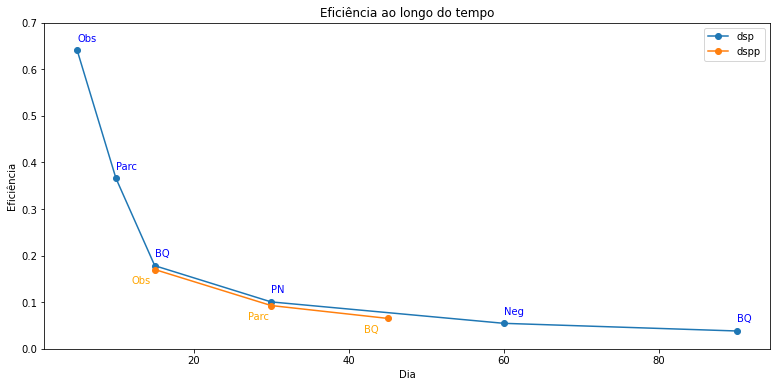

In [274]:
#eficiencia por acoes dsp
df_dsp = df_mensagem[df_mensagem['acao'].isin(dsp)][['acao', 'eficiencia']].groupby('acao').mean().sort_values('eficiencia', ascending=False).reset_index()
df_dsp['dia'] = [5,10,15,30, 60, 90 ]

#eficiencia por acoes dspp
df_dspp = df_mensagem[df_mensagem['acao'].isin(dspp)][['acao', 'eficiencia']].groupby('acao').mean().sort_values('eficiencia', ascending=False).reset_index()
df_dspp['dia'] = [15, 30 , 45 ]


#plot grafico
plt.figure(figsize=(13,6))
plt.plot(df_dsp['dia'], df_dsp['eficiencia'], marker='o');
plt.plot(df_dspp['dia'], df_dspp['eficiencia'], marker='o');
plt.xlabel('Dia')
plt.ylabel('Eficiência')
plt.title('Eficiência ao longo do tempo')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN','Neg', 'BQ']
d_dsp = [5,10,15, 30, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [15, 30, 45]

#legenda das acoes
for i in range(len(d_dsp)):
    plt.annotate(c_dsp[i], (d_dsp[i],df_dsp['eficiencia'][i]+0.02), color='b')

for i in range(len(d_dspp)):
    plt.annotate(c_dspp[i], (d_dspp[i]-3,df_dspp['eficiencia'][i]-0.03), color='orange')
    


### Régua proposta

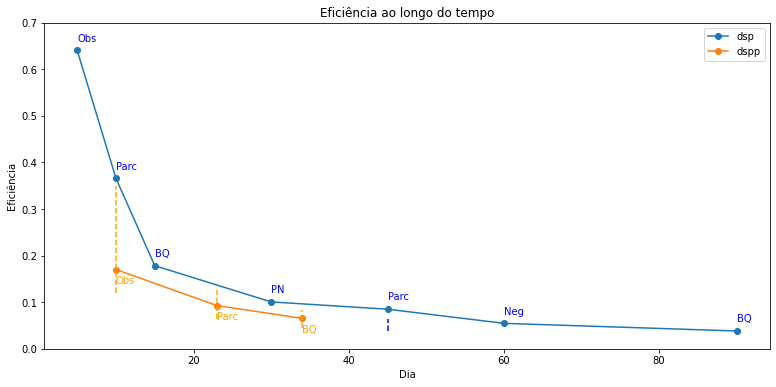

In [255]:
# adicionando campanha de parcelamento (15dsp)
nova_campanha = pd.DataFrame({'acao': 'campanhaparcelamento45', 'eficiencia':  0.085, 'dia': 45}, index=[len(df_dsp)+1])
df_dsp_ = pd.concat([df_dsp, nova_campanha]).sort_values('dia').reset_index(drop=True)

#alterando dias da régua dspp
df_dspp_ = df_dspp.copy()
df_dspp_['dia'] = [10, 23, 34]

#plot grafico
plt.figure(figsize=(13,6))
plt.plot(df_dsp_['dia'], df_dsp_['eficiencia'], marker='o');
plt.plot(df_dspp_['dia'], df_dspp_['eficiencia'], marker='o');
plt.xlabel('Dia')
plt.ylabel('Eficiência')
plt.title('Eficiência ao longo do tempo')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN','Parc', 'Neg', 'BQ']
d_dsp = [5,10,15, 30,45, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [15, 30, 45]

# #legenda das acoes
for i in range(len(df_dsp_)):
    plt.annotate(c_dsp[i], (df_dsp_['dia'][i], df_dsp_['eficiencia'][i]+0.02), color='b')

for i in range(len(df_dspp_)):
    plt.annotate(c_dspp[i], (df_dspp_['dia'][i], df_dspp_['eficiencia'][i]-0.03), color='orange')
    
#desenhando range de eficiencia
plt.axvline(df_dspp_['dia'][0],ymin=df_dspp['eficiencia'][0],ymax=0.5,color='orange', linestyle='--')
plt.axvline(df_dspp_['dia'][1],ymin=df_dspp['eficiencia'][1],ymax=0.18,color='orange', linestyle='--')
plt.axvline(df_dspp_['dia'][2],ymin=df_dspp['eficiencia'][2],ymax=0.12,color='orange', linestyle='--');
plt.axvline(45,ymin=df_dsp_['eficiencia'][5],ymax=0.09,color='b', linestyle='--');


Curva estimada de como estariam dispostas as campanhas na nova régua.

As linhas pontilhadas estima a eficiênca das novas campanhas de acordo com a curva de engajamento atual. A curva real poderia ser construída e validaria a nova estratégia ou não.


#### Zoom na mudança de régua dspp

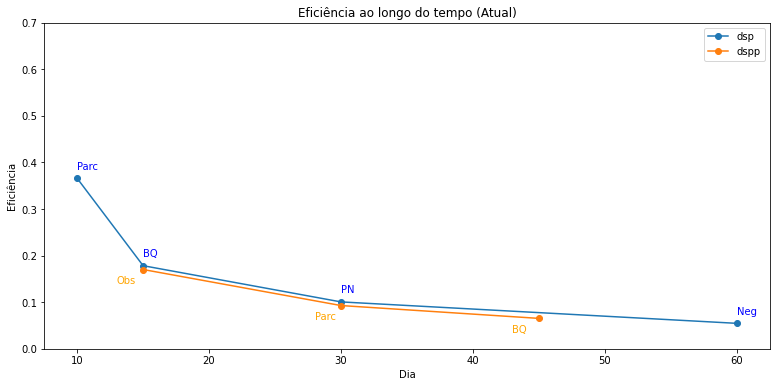

In [276]:

plt.figure(figsize=(13,6))
plt.plot(df_dsp['dia'][1:5], df_dsp['eficiencia'][1:5], marker='o');
plt.plot(df_dspp['dia'], df_dspp['eficiencia'], marker='o');
plt.xlabel('Dia')
plt.ylabel('Eficiência')
plt.title('Eficiência ao longo do tempo (Atual)')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN', 'Neg', 'BQ']
d_dsp = [5,10,15, 30, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [df_dspp['dia'][0], df_dspp['dia'][1], df_dspp['dia'][2]]

for i in range(1,len(d_dsp)-1):
    plt.annotate(c_dsp[i], (d_dsp[i],df_dsp['eficiencia'][i]+0.02), color='b')

for i in range(len(d_dspp)):
    plt.annotate(c_dspp[i], (d_dspp[i]-2,df_dspp['eficiencia'][i]-0.03), color='orange')
    


# plt.annotate('Melhor \nengajamento',(2, 0.08) );

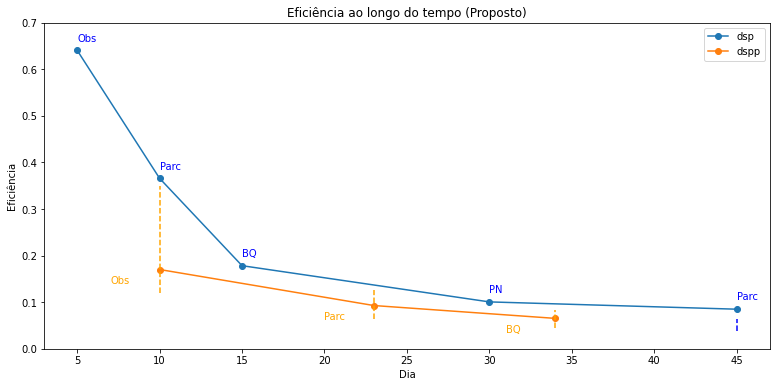

In [267]:
df_dspp['dia'] = [10, 23, 34]

plt.figure(figsize=(13,6))
plt.plot(df_dsp_['dia'][:5], df_dsp_['eficiencia'][:5], marker='o');
plt.plot(df_dspp['dia'], df_dspp['eficiencia'], marker='o');
plt.xlabel('Dia')
plt.ylabel('Eficiência')
plt.title('Eficiência ao longo do tempo (Proposto)')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN','Parc', 'Neg', 'BQ']
d_dsp = [5,10,15, 30, 45 , 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [df_dspp['dia'][0], df_dspp['dia'][1], df_dspp['dia'][2]]

for i in range(len(d_dsp)-2):
    plt.annotate(c_dsp[i], (d_dsp[i],df_dsp_['eficiencia'][i]+0.02), color='b')

for i in range(len(d_dspp)):
    plt.annotate(c_dspp[i], (d_dspp[i]-3,df_dspp['eficiencia'][i]-0.03), color='orange')
    
plt.axvline(df_dspp['dia'][0],ymin=df_dspp['eficiencia'][0],ymax=0.5,color='orange', linestyle='--')
plt.axvline(df_dspp['dia'][1],ymin=df_dspp['eficiencia'][1],ymax=0.18,color='orange', linestyle='--')
plt.axvline(df_dspp['dia'][2],ymin=df_dspp['eficiencia'][2],ymax=0.12,color='orange', linestyle='--');
plt.axvline(45,ymin=df_dsp_['eficiencia'][5],ymax=0.09,color='b', linestyle='--');


# plt.annotate('Melhor \nengajamento',(2, 0.08) );

##### Zoom na mudança na régua dsp

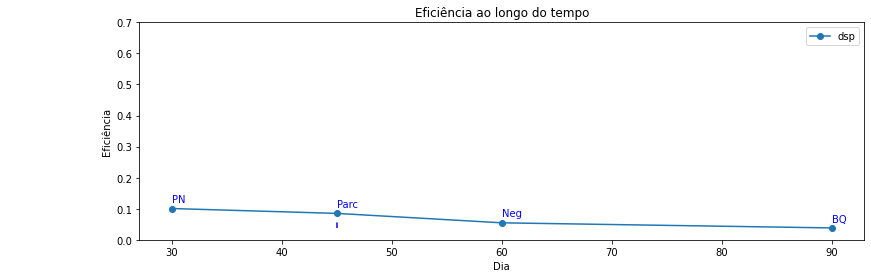

In [166]:
df_dspp['dia'] = [10, 23, 40]

plt.figure(figsize=(13,4))
plt.plot(df_dsp_['dia'][3:], df_dsp_['eficiencia'][3:], marker='o');
# plt.plot(df_dspp['dia'][2:], df_dspp['eficiencia'][2:], marker='o');
plt.xlabel('Dia')
plt.ylabel('Eficiência')
plt.title('Eficiência ao longo do tempo')
plt.legend(['dsp', 'dspp']);
plt.ylim(0, 0.7)

c_dsp = ['Obs', 'Parc', 'BQ', 'PN', 'Parc','Neg', 'BQ']
d_dsp = [5,10,15, 30, 45, 60, 90]

c_dspp = ['Obs', 'Parc', 'BQ']
d_dspp = [10, 23, 40]

for i in range(2,len(d_dsp)):
    plt.annotate(c_dsp[i], (d_dsp[i],df_dsp_['eficiencia'][i]+0.02), color='b')

plt.axvline(45,ymin=df_dsp_['eficiencia'][5],ymax=0.09,color='b', linestyle='--');

    

# plt.annotate('Melhor \nengajamento',(2, 0.08) );